# ANN + GMM Ensemble Model
## Chester 202018020317

# 1. Import Libraries

In [446]:
from scipy.stats import mode
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import glob
from PIL import Image
import os
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

# 2. Tools Preparation

# 2.1 ReLU Activation Function
This is a custom ReLU activation function that returns the maximum of 0 and the input value.
The reason for using this custom activation function is that the GMM model requires the input to be non-negative.
The formula is as follows:
$$
f(x)=\max (0, x)
$$

Where:
- $x$ is the input value
- $f(x)$ is the output value

In [447]:
def relu(x):
    """
    Custom ReLU activation function
    :param x: input value
    :return: output value
    """
    return tf.maximum(0.0, x)

# 2.2 softmax Activation Function
This is a custom softmax activation function that returns the softmax of the input value.
The reason for using this custom activation function is that the GMM model requires the input to be non-negative.
The formula is as follows:
$$
\[
\sigma(\mathbf{z})_{j}=\frac{e^{z_{j}}}{\sum_{k=1}^{K} e^{z_{k}}}
\]
$$

Where:
- $z$ is the input value
- $j$ is the $j$-th element of the input value
- $K$ is the number of elements in the input value

In [448]:
def softmax(x):
    """
    Custom softmax activation function
    :param x: input value
    :return: output value
    """
    return tf.exp(x) / tf.reduce_sum(tf.exp(x))

# 2.4 Custom Loss Function
This is a custom loss function that calculates the loss of the model's predictions.
The formula is as follows:
$$
\[
L = -\sum_{c=1}^{M} y_{\text{true}, c} \cdot \log(y_{\text{pred}, c})
\]
$$

Where:
- $M$ is the number of classes
- $y_{\text{true}, c}$ is the true label of the $c$-th class
- $y_{\text{pred}, c}$ is the predicted label of the $c$-th class

In [449]:
def custom_loss(y_true, y_pred):
    """
    Custom loss function
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: loss
    """
    return -tf.reduce_mean(y_true * tf.math.log(y_pred))

# 3. Model Definition

## 3.1 ANN Model
This ANN model performs the classification task by learning the complex mapping relationship between the input car label images) and the categories of the output car labels. This ANN is designed to have multiple hidden layers with multiple neurons per hidden layer (these two parameters can be changed while building the model). It is responsible for extracting features from the input image and mapping these features to the output layer, where each neuron in the output layer represents the predicted probability of a category. Since the ANN knowledge integrates a part of the model, the output of the ANN (feature vector) is not used directly for classification decisions but as input to the GMM.

In [450]:
class ANNClassifier:
    def __init__(self, input_shape, num_classes, hidden_layers_sizes):
        """
        The constructor of the ANNClassifier class.
        :param input_shape: The shape of the input data
        :param num_classes: The number of classes
        :param hidden_layers_sizes: The sizes of the hidden layers
        """
        self.model = Sequential()
        self.model.add(Flatten(input_shape=input_shape))
        for size in hidden_layers_sizes:
            self.model.add(Dense(size, activation=relu))
        self.model.add(Dense(num_classes, activation=softmax))

    def compile(self, optimizer):
        """
        Compiles the model.
        :param optimizer: The optimizer to use
        """
        self.model.compile(optimizer=optimizer, loss=custom_loss)

    def fit(self, X, y, epochs, batch_size):
        """
        Fits the model to the training data.
        :param X: the training data
        :param y: the training labels
        :param epochs: the number of epochs
        :param batch_size: the batch size
        :return: the history of the training process
        """
        self.history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size)
        return self.history

    def predict(self, X):
        """
        Predicts the labels of the data.
        :param X: the data used for prediction
        :return: the predicted labels
        """
        return self.model.predict(X)

## 3.2 GMM Model
In this integrated model, the role of the GMM is to cluster the output of the ANN. Specifically, it clusters the feature vectors of the ANN output into a number of classes, each representing a set of car labels with similar features.

In [451]:
class GMMClassifier:
    def __init__(self, n_components):
        """
        The constructor of the GMMClassifier class.
        :param n_components: The number of components
        """
        self.gmm = GaussianMixture(n_components=n_components)

    def fit(self, X):
        self.gmm.fit(X)

    def predict(self, X):
        return self.gmm.predict(X)

## 3.3 Ensemble Model
This is the integrated model that combines the ANN and GMM models. It takes the ANN and GMM models as input and uses the ANN model to extract features from the input data and the GMM model to cluster the extracted features.

In [452]:
class Ensemble:
    def __init__(self, supervised_model, unsupervised_model):
        """
        The constructor of the Ensemble class.
        :param supervised_model: the supervised model - ANN
        :param unsupervised_model: the unsupervised model - GMM
        """
        self.supervised_model = supervised_model
        self.unsupervised_model = unsupervised_model

    def fit(self, X, y, epochs, batch_size):
        """
        Fits the model to the training data.
        :param X: the training data
        :param y: the training labels
        :param epochs: the number of epochs in the ANN
        :param batch_size: the batch size in the ANN
        :return: the history of the training process
        """
        # Fit ANN
        loss_history = self.supervised_model.fit(X, y, epochs, batch_size)

        # Get ANN predictions to use as features for GMM
        ann_predictions = self.supervised_model.predict(X)

        # Fit GMM with features from ANN
        self.unsupervised_model.fit(ann_predictions)
        
        return loss_history

    def predict(self, X):
        """
        Predicts the labels of the data.
        :param X: the data used for prediction
        :return: the predicted labels
        """
        # Get ANN predictions to use as features for GMM
        predictions = self.supervised_model.predict(X)
        # Predict with GMM
        return self.unsupervised_model.predict(predictions)

# 4. Data Preparation
This section contains the code for loading and preprocessing the data.

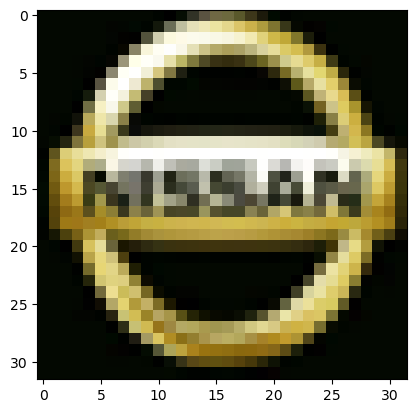

In [462]:
def load_images(image_paths, target_size):
    images = []
    labels = []
    for image_path in image_paths:
        # Load image
        img = Image.open(image_path).convert('RGB')  # Convert to RGB format
        img = img.resize(target_size)  # Resize image to target size
        img_array = np.array(img)  # Convert to numpy array
        images.append(img_array)
        # Extract label from file path
        label = os.path.basename(os.path.dirname(image_path))
        labels.append(label)
        
    # Normalize pixel values
    images = np.array(images, dtype='float32') / 255.0  
    # Convert labels to integer encoding
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    # Convert labels to one-hot encoding
    labels = tf.keras.utils.to_categorical(labels)  
    return images, labels

# Load images
image_paths = glob.glob('Car_Logo_Dataset/**/*.png', recursive=True)
X, y = load_images(image_paths, target_size=(32, 32))

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.imshow(X_test[5])

# 5. Model Construction & Training

In [454]:
ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1], hidden_layers_sizes=(128, 128, 128, 128))
ann.compile(optimizer=tf.keras.optimizers.Adam())
gmm = GMMClassifier(n_components=y_train.shape[1])
ensemble = Ensemble(ann, gmm)

In [455]:
history = ensemble.fit(X_train, y_train, epochs=30, batch_size=32)

y_pred = ensemble.predict(X_test)
y_test = np.argmax(y_test, axis=1)

Epoch 1/30


2023-12-03 20:47:28.727781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 25ms/step - loss: 0.2089
Epoch 2/30
14/14 [==============================] - 0s 12ms/step - loss: 0.1638
Epoch 3/30
14/14 [==============================] - 0s 10ms/step - loss: 0.1313
Epoch 4/30
14/14 [==============================] - 0s 9ms/step - loss: 0.1325
Epoch 5/30
14/14 [==============================] - 0s 10ms/step - loss: 0.1288
Epoch 6/30
14/14 [==============================] - 0s 8ms/step - loss: 0.1212
Epoch 7/30
14/14 [==============================] - 0s 9ms/step - loss: 0.1184
Epoch 8/30
14/14 [==============================] - 0s 9ms/step - loss: 0.1159
Epoch 9/30
14/14 [==============================] - 0s 9ms/step - loss: 0.1148
Epoch 10/30
14/14 [==============================] - 0s 9ms/step - loss: 0.1171
Epoch 11/30
14/14 [==============================] - 0s 9ms/step - loss: 0.1192
Epoch 12/30
14/14 [==============================] - 0s 8ms/step - loss: 0.1174
Epoch 13/30
14/14 [==============================] - 0s 

2023-12-03 20:47:33.117109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 21ms/step


# 6. Model Evaluation
## 6.1 Plot History

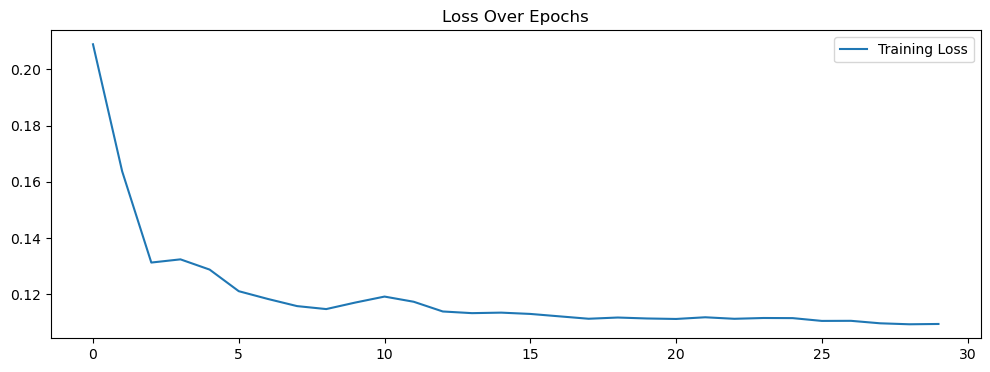

Final cost: 0.10951221734285355


In [456]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.show()
    
plot_history(history)
print('Final cost:', history.history['loss'][-1])

# 6.2 Remap Labels

In [457]:
def remap_labels(true_labels, predicted_labels):
    unique_true_labels = np.unique(true_labels)
    mapped_labels = np.zeros_like(predicted_labels)
    for true_label in unique_true_labels:
        mask = (true_labels == true_label)
        # Find the cluster label that most frequently occurs with this true label
        most_common = mode(predicted_labels[mask])[0][0]
        mapped_labels[predicted_labels == most_common] = true_label
    return mapped_labels

mapped_predictions = remap_labels(y_test, y_pred)

/var/folders/fm/_6wfn0r96gjcpy7779d0j2fc0000gn/T/ipykernel_44430/1066602501.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common = mode(predicted_labels[mask])[0][0]


## 6.3 Confusion Matrix

Recall: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
Precision: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
F1 Score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
Confusion Matrix:
[[5. 0. 0. ... 0. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]
 [0. 0. 2. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 4.]]


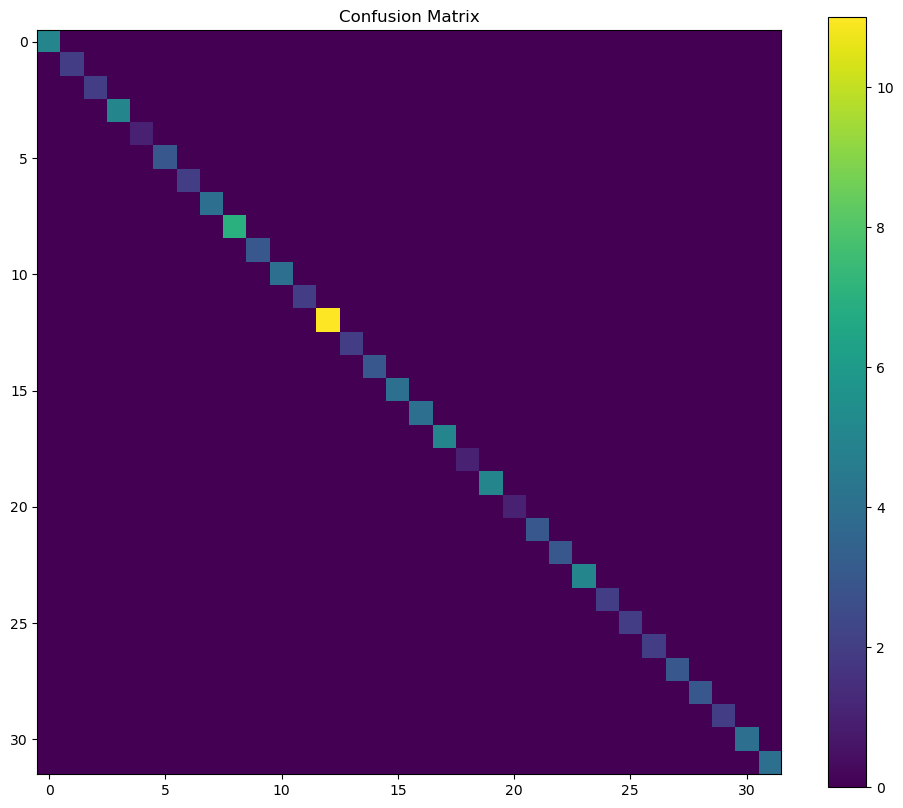

In [458]:
def confusion_matrix(y_true, y_pred):
    """
    The confusion_matrix function is used to compute the confusion matrix of the model.
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the confusion matrix of the model
    """
    num_classes = len(np.unique(y_true))
    result = np.zeros((num_classes, num_classes))
    for i in range(len(y_true)):
        result[y_true[i]][y_pred[i]] += 1
        
    true_positive = np.diag(result)
    false_positive = np.sum(result, axis=0) - true_positive
    false_negative = np.sum(result, axis=1) - true_positive
    
    recall = true_positive / (true_positive + false_negative)
    precision = true_positive / (true_positive + false_positive)
    f1_score = 2 * precision * recall / (precision + recall)
    
    print('Recall:', recall)
    print('Precision:', precision)
    print('F1 Score:', f1_score)
    
    return result

conf_matrix = confusion_matrix(y_test, mapped_predictions)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix, cmap='viridis')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

# 6.4 Accuracy
This is a custom accuracy function that calculates the accuracy of the model's predictions.
The formula is as follows:
$$
\[
\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}(y_{\text{true}, i} = y_{\text{pred}, i})
\]

$$

Where:
- $N$ is the number of samples
- $y_{\text{true}, i}$ is the true label of the $i$-th sample
- $y_{\text{pred}, i}$ is the predicted label of the $i$-th sample

In [459]:
def custom_accuracy(y_true, y_pred):
    """
    Custom accuracy function
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: accuracy
    """
    correct_predictions = tf.equal(y_true, y_pred)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32)) * 100

print(f"Accuracy: {custom_accuracy(y_test, mapped_predictions).numpy():.3f}%")

Accuracy: 100.000%


# 6.5 Visualization

4/4 [==============================] - 0s 6ms/step


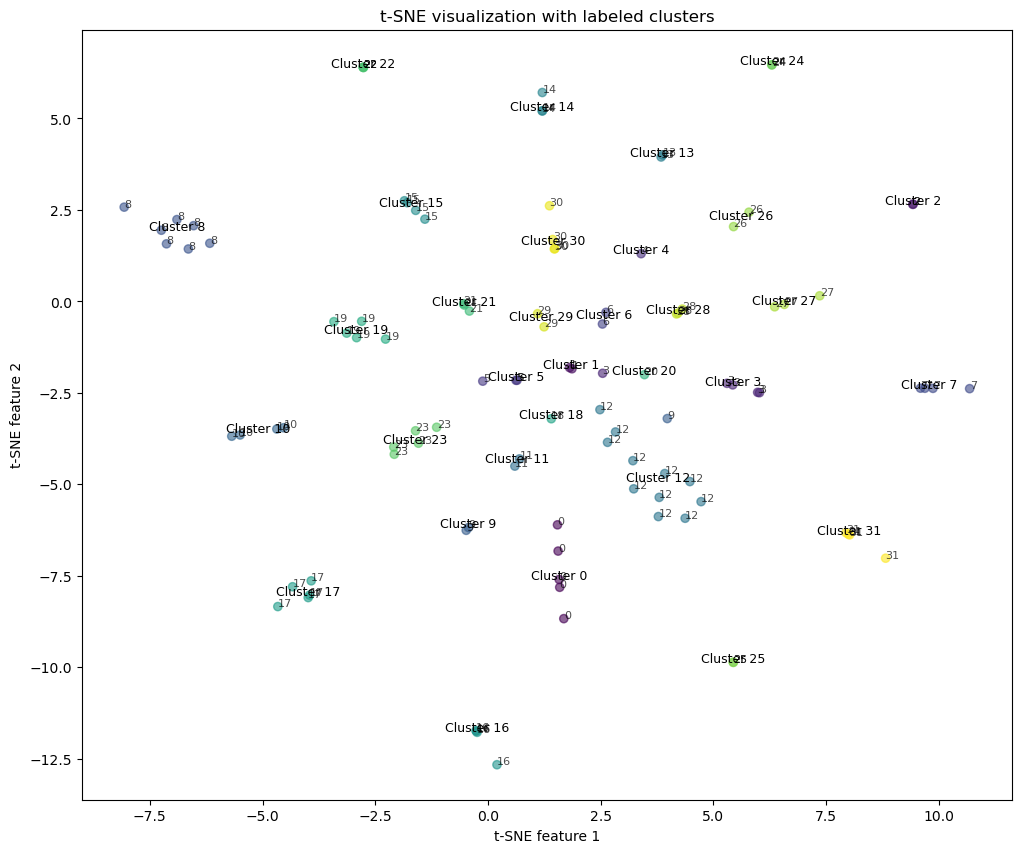

In [460]:
def visualize_clusters_with_labels(X, y, model):
    # use the model to predict the labels of the data samples
    features = model.predict(X)

    # use t-SNE to reduce the features to 2 dimensions
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    X_reduced = tsne.fit_transform(features)

    # plot the 2D data points
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.6)

    # create a legend
    unique_labels = np.unique(y)
    for i, label in enumerate(unique_labels):
        xtext, ytext = np.median(X_reduced[y == label, :], axis=0)
        txt = f'Cluster {label}'
        plt.annotate(txt, (xtext, ytext), fontsize=9, ha='center')

    for i, txt in enumerate(y):
        plt.annotate(txt, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=8, alpha=0.7)

    #plt.legend(handles=scatter.legend_elements()[0], labels=set(y), title="Clusters")
    plt.title('t-SNE visualization with labeled clusters')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()

visualize_clusters_with_labels(X_test, mapped_predictions, ann)